In [2]:
from itertools import chain
# from neuron import h, gui
import pandas
%pylab inline
import cPickle as pickle
from scipy.signal import *
import efel

Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
R = 8314.4  # Gaz constant, mJ / mol / K
F = 96485   # Faraday's, C / mol
F_ATP = 50 # Free energy of ATP hydrolysis, kJ / mol (Moujahid et al, 2014)
avogadro = 6.022e23 # N_a

In [8]:
h.celsius = 33. # 37.

In [9]:
h.cvode_active(0)
h.dt = 0.005

In [10]:
def find_nearest(array, value):
    idx = np.abs(array - value).argmin()
    return idx

# Cotopus cell model (Spencer et al, 2012)

In [11]:
# number of segments per dendrite should be large to allow for precise synapse location. So set Ndendseg=201

Ndend = 4
    
class OctopusCell:
    all_currents = ['leak', 'nasab', 'kltab', 'khtab', 'ihsab']
    def __init__(self, 
                 soma_diam=25.0,
                 ax_init_L=5.0,
                 ax_passive_L=35.0,
                 ax_diam=3.0,
                 Ndend=4, Ndendseg = 201, dend_L=250., dend_diam=3.0,
                 ax_gbar_na = 1600,  # mS/cm^2
                 ax_gbar_Ikl = 10,    # ??? Why not Ikh?
                 soma_gbar_Ikl = 40.7, # mS/cm^2
                 soma_gbar_Ih = 7.6,   # mS/cm^2
                 dend_gbar_Ikl = 2.7,  # mS/cm^2 ; Table 3 Spencer 2012
                 dend_gbar_Ih = 0.6,   # mS/cm^2 ; Table 3 Spencer 2012
                 cm = 1.2, # uF/cm^2, closer to McGinley et al 2012
                 Ra = 150., #Ohm*cm, closer to McGinley et al 2012 
                 Eleak=-62):
        self.id = randint(10000000)
        #self.Eleak = Eleak
        self.make_soma(soma_diam)
        self.make_axon(ax_init_L, ax_passive_L,ax_diam)
        self.make_dendrites(Ndend,Ndendseg,dend_L,dend_diam)
        self.make_connections()
        self.init_mechanisms(ax_gbar_na, ax_gbar_Ikl,
                             soma_gbar_Ikl, soma_gbar_Ih,
                             dend_gbar_Ikl, dend_gbar_Ih,
                             cm, Ra, Eleak)
        
        self.add_stim()
        self.init_records()
        
    def add_stim(self):
        self.stim = h.IClamp(0.5, sec=self.soma)
        self.stim.amp = 0
        
    def init_records(self):
        istim = h.Vector()
        istim.record(self.stim._ref_i)
        self.istim = istim
        
        self.tv = h.Vector()
        self.tv.record(h._ref_t) 
        
        self.vax = h.Vector()
        self.vax.record(self.ax_init(0.5)._ref_v) 
        
        self.vs = h.Vector()
        self.vs.record(self.soma(0.5)._ref_v) 
        
        
        
    def make_soma(self,diam):
        # Soma
        soma = h.Section(name='soma_%d'%self.id)
        soma.L = soma.diam = diam
        soma.nseg = 1
        self.soma = soma

    def make_axon(self, ax_init_len=10, ax_passive_len=30,diam=3.0):
        # Axon
        ax_stub = h.Section(name='ax_stub%d'%self.id)
        ax_init = h.Section(name='ax_init%d'%self.id)
        ax_stub.diam = ax_init.diam = diam
        ax_stub.L = ax_passive_len
        ax_init.L = ax_init_len
       
        ax_init.nseg = int(ceil(ax_init.L/10))
        ax_stub.nseg = int(ceil(ax_stub.L/10))
        
        self.ax_init = ax_init
        self.ax_stub = ax_stub
    

    def make_dendrites(self,  Ndend=4, Ndendseg=201, L=250, diam=3.0):
        # Dendrites
        dendrites = [h.Section(name='dend_%d_%d'%(i,self.id)) for i in range(Ndend)]
        for d in dendrites:
            d.diam = 3
            d.L = L
            d.nseg = Ndendseg
            #d.connect(soma, 1, 0)
        self.dendrites = dendrites
    
    def make_connections(self):
        self.ax_init.connect(self.ax_stub, 1, 0)   # childsec.connect(parentsec, parentx, childx)
        self.ax_stub.connect(self.soma, 0, 0)
        for d in self.dendrites:
            d.connect(self.soma, 1, 0)
    
    def init_mechanisms(self, 
                        ax_gbar_na, ax_gbar_Ikl,
                        soma_gbar_Ikl, soma_gbar_Ih,
                        dend_gbar_Ikl, dend_gbar_Ih, 
                        cm, Ra, Eleak):
        sections = [self.soma, self.ax_init, self.ax_stub]+self.dendrites
        for sec in sections:
            sec.Ra = Ra  
            #sec.cm = 0.9      # Spencer
            sec.cm = cm      
            for cur in self.all_currents:
                sec.insert(cur)
            for seg in sec:
                seg.leak.erev = Eleak
                seg.leak.g = 0.002  # Spencer
                #seg.hcno.eh = -38
                seg.ihsab.eh = -38 # Spencer
            
                seg.nasab.gbar = 0
                seg.ihsab.gbar = 0
                seg.kltab.gbar = 0
                seg.khtab.gbar = 0
                #seg.hcno.gbar = 0
            
            sec.ena = 55.0
            sec.ek = -70.0
    
        # ... there must be a more compact way...
        # todo: tabulate these parameters
        #for seg in self.ax_stub:
        #    seg.leak.g = 0
        for seg in self.ax_init:
            seg.nasab.gbar = ax_gbar_na*1e-3
            seg.kltab.gbar = ax_gbar_Ikl*1e-3
       
        for seg in self.soma:
            seg.kltab.gbar = soma_gbar_Ikl*1e-3
            seg.ihsab.gbar = soma_gbar_Ih*1e-3
            seg.khtab.gbar = 0.0061
            
    
        for seg in chain(*self.dendrites):
            seg.kltab.gbar = dend_gbar_Ikl*1e-3
            seg.ihsab.gbar = dend_gbar_Ih*1e-3
    
    def delete(self):
        self.soma = None
        self.ax_init = None
        self.ax_stub = None
        self.dendrites = None
    
    def add_synapses(self,
                     Nsyn = 100, # total number of impinging synapses
                     gsyn = 1.5, # single synaptic conductance nS
                     tau_rise = 0.07,
                     tau_decay = 0.34,
                     #-- 
                     tonotopy = 'ordered', # {ordered, random}
                     full_delay = 0.3, # max difference between delays, ms
                     #--
                     aud_rate=211,    # incoming spike rate, Hz
                     aud_start = 100, # ms
                     aud_npulses=25,  # number of incoming spikes 
                     aud_jitter = 0.0, # jitter of incoming spike times (0...1)
                    ):
        afib = h.NetStim()

        afib.interval = 1000./aud_rate # ms 
        afib.start = aud_start # ms
        afib.number = aud_npulses # number of spikes
        afib.noise = aud_jitter # no randomness so far
        self.afib = afib
        
        synapses = []
        delays = linspace(0,full_delay, Nsyn) # !!! Delay distribution could be non-uniform!
        #delays = uniform(0.0,full_delay,size=Nsyn) # !!! Delay distribution could be non-uniform!
        for k in xrange(Nsyn):
            delay = delays[k]
            if tonotopy == 'ordered':
                loc = 1 - delay/full_delay
            elif tonotopy == 'random':
                loc = uniform()
            d = self.dendrites[randint(len(self.dendrites))]
            syn = h.Exp2Syn(loc, sec=d) 
            syn.tau1 = tau_rise # rise time
            syn.tau2 = tau_decay # decay time
            con  = h.NetCon(afib, syn, 0, delay, gsyn*1e-3) #nS->uS
            synapses.append((syn, con, d(loc), delay))
        self.synapses = synapses
        return
    def _shuffle_synapses(self):
        if not self.synapses:
            return
        for syn,con,seg in self.synapses:
            d = self.dendrites[randint(len(self.dendrites))]
            loc = uniform()
            #....syn.

#################################################################_OZ_16.02.17

    def set_afib(self,
                 aud_rate=211,    # incoming spike rate, Hz
                 aud_start=200, # ms
                 aud_npulses=25,  # number of incoming spikes 
                 aud_jitter=0.0, # jitter of incoming spike times (0...1)):
                 ):
        afib = h.NetStim()
        afib.interval = 1000./aud_rate # ms 
        afib.start = aud_start # ms
        afib.number = aud_npulses # number of spikes
        afib.noise = aud_jitter # no randomness so far
        self.afib = afib
        return afib
    
    
    def add_single_syn(self,
                       loca, # location [0...1] of the synapse
                       afib,
                       gsyn = 1.5, # single synaptic conductance nS
                       tau_rise = 0.07,
                       tau_decay = 0.34,
                       tonotopy = 'ordered', # {ordered, random}
                       delay_func=None,
                       dnm=0   # indice of a dend from the dendrites list
                     ):
        
        # Make a synapse
        d = self.dendrites[dnm]
        syn = h.Exp2Syn(loca, sec=d)
        syn.tau1 = tau_rise # rise time
        syn.tau2 = tau_decay # decay time

        if tonotopy == 'ordered':
            if delay_func == None:
                delay = 0 # ******** To Be Corrected Later ******* ???? Make a linear distr
            else:
                delay = delay_func(loca)
        elif tonotopy == 'random' and delay_func != None:
            delay = uniform(delay_func(0), delay_func(1))

#         print loca,delay

        con = h.NetCon(afib, syn, 0, delay, gsyn*1e-3) #nS->uS            
#         self.syn=syn
#         self.con=con
        
        synapse = (syn,con,d(loca),delay)
        self.synapse = synapse
        return synapse


    def add_several_syn(self,
                        locs,  
                        gsyn = 1.5, # single synaptic conductance nS
                        tau_rise = 0.07,
                        tau_decay = 0.34,
                        tonotopy = 'ordered', # {ordered, random}
                        delay_func=None,
                        afibp=dict(aud_rate=211,   
                                   aud_start=200,   
                                   aud_npulses=1,    
                                   aud_jitter=0.0), 
                        dnm=0,
                       ):
        afib = self.set_afib(**afibp)
        synapses=[]
        if type(dnm) == int:
#             print 'dnm is INT MFFCR!'
            for loc in locs:
                synapses.append(self.add_single_syn(loca=loc,
                                                    afib=afib,
                                                    gsyn=gsyn,
                                                    tau_rise=tau_rise,
                                                    tau_decay=tau_decay,
                                                    tonotopy=tonotopy,
                                                    delay_func=delay_func,
                                                    dnm=dnm
                                                   )
                                )
            self.synapses=synapses
            
        elif type(dnm) == list:
#             for d in dnm:
            for loc in locs: # now locs are the coordinates of all synapses to be distributed 
                             # amond all dends with indices from dnm
                d = dnm[randint(len(dnm))]
                synapses.append(self.add_single_syn(loca=loc,
                                                afib=afib,
                                                gsyn=gsyn,
                                                tau_rise=tau_rise,
                                                tau_decay=tau_decay,
                                                tonotopy=tonotopy,
                                                delay_func=delay_func,
                                                dnm=d
                                               )
                            )
            self.synapses=synapses
        
        return
    
    def find_delays(self,    # *** NOTE, tau_rise(0->Vmax) lowers in case of preceeding EPSP! ***
                    locs, # locs: .0->1.
                    v_init=-61.1,
                    afibp=dict(aud_rate=211,   
                               aud_start=200,  
                               aud_npulses=1,  
                               aud_jitter=0.0),
                    dnm=0,
                   ):
        acc=[]
        acc1=[]
        afib=self.set_afib(**afibp)

        for loc in locs:
            self.add_single_syn(loca=loc, afib=afib, dnm=dnm)
            # *.add_single_syn overwrites *Dend.synapse* variable at every iteration. The last is not deleted

            vx = h.Vector()
            vx.record(self.dendrites[dnm](loc)._ref_v)
            v1 = h.Vector()
            v1.record(self.dendrites[dnm](0.0)._ref_v)   # 'destination' region (0.0 fixed to soma(1))
            t = h.Vector()
            t.record(h._ref_t)

            h.tstop = 300
            h.v_init = -60.0
            h.run()
            
#             print array(v0).max(), array(v1).max()

            t_ = find_nearest(array(t),100)  # indice to begin reading Vs from, avoiding relaxation, what may be higher than EPSP
#             print t_, array(vx)==array(vx)[t_:].max(), array(vx)==array(vx).max()
        
            tx_max = array(t)[array(vx)==array(vx)[t_:].max()]  # time when Vm reaches max at the *loc* coordinate
            t1_max = array(t)[array(v1)==array(v1)[t_:].max()]  # -||- at the 'destination' coordinate 
            taux = tx_max-afibp['aud_start']                    # the time of Vmax appear at the x coordinate relatively to aud_start moment
#             print t0_max, t1_max
            
            acc.append([loc,
#                         t1_max-afibp['aud_start'],
#                         t1_max-tx_max])   # synapse location and corresponding delay times, both relative to
                        t1_max])                                           # aud_start and t0_max
            acc1.append(map(array, [t,vx,v1]))
        acc = transpose(acc)
        return acc, acc1    

# Energy calc functions

In [12]:
def split_mixed(v, gm, erev,ek=-70,ena=55):
    gratio = float((ena-erev))/(erev-ek)
    denom = (v*(gratio+1) - gratio*ek - ena)
    if (abs(v-erev) < 1):
        gnah = gm/(gratio + 1)
    else: 
        gnah = gm*(v-erev)/denom
    inah = gnah*(v-ena)
    ikh = gratio*gnah*(v-ek)
    return inah, ikh

def ratp_atwell(V, Rin, Ena = 50, Ek = -70):
    """ Ion-counting (formula)
        Returns resting ATP consumption rate (pmol ATP/s)
        [eq. 4 in Attwell & Laughlin, 2001]
        """
    
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol


# ---- Energy units convertation funcs ----


def pmol2molecules(x):
    "pmol ATP/s --> ATPs/s"
    return x*1e-12*avogadro

def atp2J(nATP):
    "pmol ATP/s --> pJ/s"
    return F_ATP * nATP * 1e3

def J2atp(nJ, F_ATP=50):
    "J/s --> mol ATP/s"
    return (nJ/F_ATP)*1e-3

def pJ2molecules(pJ):
    "pJ/s --> ATPs/s"
    return pmol2molecules(J2atp(pJ))


# ---- Energy use rate (Moujahid et al, 2011) ----


def mouj_Erate2(seg, erev_ih = -38, mode=None, atwla=False):
    """
    
    Calculate energy from all currents (*density mechanisms only*) in the model 
    segment (pJ/s or ATPs/s, see atwla). 
    
    Synaptic currents-related energy is not calculated here.
    
    mode==None => total energy from all currents calculated;
    mode=='hkl' => total & h-current-related & 
                    klt-current-related & leakage-related energies are packed into a single list
    
    atwla=False => Biophysical method is adopted (Moujahid et al 2011) (pJ/s)
    atwla=True => Ion-counting method is adopted(Attwell & Laughlin 2001) (ATPs/s)
    
    -------
    Returns: list of float(s)
    """
    
    v = seg.v
    acc = 0.0
    inah, ikh = split_mixed(seg.v, seg.gh_ihsab, 
                            erev_ih, seg.ek, seg.ena) # Split Ih into Na and K components

    ina = seg.ina + inah      # Total Na current, mA/cm2
    ik = seg.ik + ikh         # Total K current

    if atwla:
        factor = 1e-3 * 1e-8 / 1.6e-19 # powers of 10: mA/cm2->A/cm2, um2->cm2, => A, => ions/s
        acc = abs(ina) / 3 * factor * seg.area()
        if mode is None:
            
            return [acc]
        
        elif mode == 'hkl':
            acch = abs(inah) / 3 * factor * seg.area()
            acckl = abs(seg.kltab.ik) / 2 * factor * seg.area()
            acclk = abs(seg.i_leak) / 2 * factor * seg.area() # assuming K leakage
            
            return [acc, acch, acckl, acclk]
        
    else:
        acc += ina*(v-seg.ena)
        acc += ik*(v-seg.ek)
        acc += seg.i_leak*(v-seg.erev_leak) 
        factor = (1e-8) # um^2 -> cm^2
        factor *= (1e6) # -> pJ/s
        acc = acc*seg.area()*factor
        if mode == None:
            
            return [acc]
        
        elif mode == 'hkl':
            acch = abs(inah*(v-seg.ena)) + abs(ikh*(v-seg.ek))
            acckl = abs(seg.kltab.ik*(v - seg.ek))
            acch = acch*seg.area()*factor
            acckl = acckl*seg.area()*factor
            acclk = seg.i_leak*(v-seg.erev_leak)*seg.area()*factor
            
            return [acc, acch, acckl, acclk]
        

def synaptic_curr2pJ(syn,seg, atwla=False):
    """ 
        Calculate energy from synaptic currents.

        atwla=False => Biophysical method is adopted (Moujahid et al 2011) (pJ/s)
        atwla=True => Ion-counting method is adopted(Attwell & Laughlin 2001) (ATPs/s)

        Returns: float
    """
    # syn.g is in uS, syn.i is in nA, erate is in pJ/s
    v  = seg.v
    g = syn.g
    ina, ik = split_mixed(v, g, 0, seg.ek, seg.ena)
    if atwla:
        erate = (abs(ina) / 3) * 1e-9 / 1.6e-19 # nA -> A -> ions/s / 3
    else:
        erate = ina*(v-seg.ena) + ik*(v-seg.ek)
    return erate

### Run control from Python and energy accounting

In [13]:
tstop = 400

h.v_init = -60.6

def initialize():
    h.finitialize(h.v_init) # makes v = h.v_init and computes and fixes corresponding state variables 
    h.fcurrent() # makes all assigned variables consistent with the values of states
    
def instant_erates(cell,mode=None, atwla=False):
    """
        Calculate energy in different model compartments at a single time point (end of the model run).
    
        mode = None -> only total compartments energy count;
        mode = 'hkl' -> plus energy for Ih and Ikl throughout the compartments.
        
        atwla (True or False) -- whether use ion counting method (Attwell&Laughlin2001) or that suggested by Mougahid et al2011
        
        Returns: tuple of floats
    """
    syn_erate = np.sum([synaptic_curr2pJ(s, dseg, atwla=atwla) for s,c,dseg,d in cell.synapses])
    soma_erate = mouj_Erate2(cell.soma(0.5),mode=mode, atwla=atwla)[0] # mouj_Erate2 generates a list [acc] (mode=None) or [acc, acch, acckl] (mode='hkl')
    dend_erate = np.sum([mouj_Erate2(seg,mode=mode, atwla=atwla)[0] for seg in chain(*cell.dendrites)])
    axon_erate = np.sum([mouj_Erate2(seg,mode=mode, atwla=atwla)[0] for seg in chain(cell.ax_init,cell.ax_stub)])
    if mode == None:
        return axon_erate, soma_erate, dend_erate, syn_erate
    elif mode == 'hkl':
        h_erate = np.sum([mouj_Erate2(seg,mode=mode, atwla=atwla)[1] 
                          for seg in chain(cell.dendrites[0],cell.dendrites[1],cell.dendrites[2],cell.dendrites[3],
                                           cell.soma, cell.ax_init, cell.ax_stub)])
        kl_erate = np.sum([mouj_Erate2(seg,mode=mode, atwla=atwla)[2] 
                          for seg in chain(cell.dendrites[0],cell.dendrites[1],cell.dendrites[2],cell.dendrites[3],
                                           cell.soma, cell.ax_init, cell.ax_stub)])
        return axon_erate, soma_erate, dend_erate, syn_erate, h_erate, kl_erate
    
def integrate_collecting_energy(cells,tstop,mode=None, atwla=False):
    
    """
        Calculate time-resolved energy func for each model compartment.
        `cells` -- list of 'OctopusCell' class objects.
        
        mode==None -> only total compartments energy count;
        mode==hkl -> plus energy for Ih and Ikl throughout the compartments.

        atwla (True or False) -- whether use ion counting method (Attwell&Laughlin2001) or that suggested by Mougahid et al2011
        
        Returns: list of dicts containing energy trajectories.
    """

    keepvar = ['t','soma.v','axon.v',
               'soma.erate','axon.erate','dend.erate', 'syn.erate']
    
    if mode == 'hkl':
        keepvar += ['ih.erate','ikl.erate'] # total ih and ikl erates

    outs = [{key:[] for key in keepvar} for i in range(len(cells))]

    while h.t < tstop:
        h.fadvance() # 
        #isyn = np.sum([syn.i for syn in synapses])
        
        erates = map((lambda x: instant_erates(x, mode=mode, atwla=atwla)),cells)
        
        for cell, o, erate in zip(cells, outs, erates):
            o['t'].append(h.t)
            o['axon.v'].append(cell.ax_init.v)
            o['soma.v'].append(cell.soma.v)
            o['axon.erate'].append(erate[0]) # mouj_Erate2 generates a list [acc] (mode=None) or [acc, acch, acckl] (mode='hkl')
            o['soma.erate'].append(erate[1])
            o['dend.erate'].append(erate[2])
            o['syn.erate'].append(erate[3])
            if mode == 'hkl':
                o['ih.erate'].append(erate[4])
                o['ikl.erate'].append(erate[5])
        sys.stderr.write('\r model time: %0.5f ms '%h.t)
    sys.stderr.write('\r                                         \r\n')

    return [{key:np.array(vec) for key,vec in out.items()} for out in outs]

def go(cells,mode=None,tstop=400, atwla=False):
    initialize()
    return integrate_collecting_energy(cells, mode=mode,tstop=tstop, atwla=atwla)
    
def plot_traj(traj):
    f, axs = subplots(2,1,sharex=True, figsize=(14,9),)
    #axs = [axs]
    axs[0].plot(traj['t'], traj['axon.v'],'r-',lw=0.5,label='axon.v')
    axs[0].plot(traj['t'], traj['soma.v'],'b-',label='soma.v')
    axs[0].legend()
    
    axs[1].plot(traj['t'], traj['soma.erate'], '-', label='soma.erate')
    axs[1].plot(traj['t'], traj['dend.erate'], '-', label='dend.erate')
    axs[1].plot(traj['t'], traj['axon.erate'], '-', label='axon.erate')
    axs[1].plot(traj['t'], traj['syn.erate'], '-', color='orange', label='syn.erate')
    axs[1].legend()

### Integration

In [14]:
def integrate_fixed_window(data,timeival):
    """
        Integrate the energy traj with a fixed time window using the scipy.integrate.trapz.
        
        `data` is the output of the 'go' or 'integrate_collecting_energy' funcs.
        `interval` -- list of integration interval (ms)
    """
    
    indxival = map(lambda x: find_nearest(data['t'],x), timeival) # extract from the 't' traj indexes corresponding 
                                                                   # to the values in the indexes of the `interval`

    Esyn = trapz(y=data['syn.erate'][indxival[0]:indxival[1]], x=data['t'][indxival[0]:indxival[1]])*1e-3 # ms -> s => pJ
    Ednd = trapz(y=data['dend.erate'][indxival[0]:indxival[1]],x=data['t'][indxival[0]:indxival[1]])*1e-3 
    Eaxn = trapz(y=data['axon.erate'][indxival[0]:indxival[1]],x=data['t'][indxival[0]:indxival[1]])*1e-3 
    Esma = trapz(y=data['soma.erate'][indxival[0]:indxival[1]],x=data['t'][indxival[0]:indxival[1]])*1e-3 
    
    Ekl  = trapz(y=data['ikl.erate'][indxival[0]:indxival[1]],x=data['t'][indxival[0]:indxival[1]])*1e-3 
    Eh   = trapz(y=data['ih.erate'][indxival[0]:indxival[1]],x=data['t'][indxival[0]:indxival[1]])*1e-3 
    
    Etot = Esyn+Ednd+Esma+Eaxn
#     print 'Note, you calculate energy during %.2f ms'%(timeival[1]-timeival[0])
    acc = {'total.erate':Etot,'soma.erate':Esma,'axon.erate':Eaxn,
           'dend.erate':Ednd,'syn.erate':Esyn,'ikl.erate':Ekl,'ih.erate':Eh}
    for key,val in acc.items():
        acc[key] = J2atp(val)*6.022*(1e11)
    return acc

def integrate_only_spike(yarr, xarr, x_boarders,frac=0.05,see='no'):
    '''
        In the interval given by `x_boarders` determine the `actual boarders`
        to integrate between. A criterion is set by `frac`:
        Actual boarders are the `yarr` indices where yarr ~= frac*yarr.max()
    '''
    x0=x_boarders[0]
    x1=x_boarders[1]
    idxb0 = map(lambda x: find_nearest(xarr,x), [x0,x1])

    # Cut curve from left and right. Make yarrn for `actual boarders` determine
    yarrn = yarr[idxb0[0]:idxb0[1]]
    tail = len(yarr[:idxb0[0]]) # how much is cut from the left. 
    
    Xma = argmax(yarrn)
    th =  frac
    bsl = min(yarrn)
    
    if Xma < 0.1:
        Xma = argmin(yarrn)
        th = 1-frac
        bsl = max(yarrn)

    Xleft = find_nearest(yarrn[:Xma], th) + tail # left lim
    Xright = find_nearest(yarrn[Xma:], th) + len(yarrn[:Xma]) + tail # right lim
#     print Xleft, Xright
    # Calc yarr integral
    I0 = trapz(y=yarr[idxb0[0]:idxb0[1]]-bsl, x=xarr[idxb0[0]:idxb0[1]]) # within given boarders
    I_spike = trapz(y=yarr[Xleft:Xright]-bsl, x=xarr[Xleft:Xright]) # within ``actual boarders``
    
    if see == 'yes':
        xarray = xarr[idxb0[0]:idxb0[1]]
        figure()
        plot(xarray,yarr[idxb0[0]:idxb0[1]],label='Init Data')
#         plot(xarray,yarrn,'b',label='Init Data, normalized')
#         plot(xarray,ratios,'k--',label='Integral ratio')
#         plot(xarray[:-1], D1,label='Derivative of ratio')

        axvline(xarray[Xma],color='gray',label='Maxima')
        axvline(xarray[Xleft],color='m',label='Left')
        axvline(xarray[Xright], color='g',label='Right')
        legend(loc=6)
        show()
    
    return I_spike, I0#, Xleft+tail, Xright+tail # these are integration coordinates of init yarr
    

def integrate_all(data, x_boarders, frac=0.05, see='no',rep=0,mode=0):
    """
    `rep` == 1 => result is printed, `rep`==0 => not printed
    mode = 0 => integration within `actual boarderss`
    mode = 1 => integration within x_boarders
    """
    Erates = dict()
    x = data['t']
    for k in data.keys():
        if k[-4:] == 'rate': # collect only '.erates'
            y = data[k]
            I = array(integrate_only_spike(y, x, x_boarders=x_boarders, frac=frac, see=see))*1e-3 # ms->s => pJ
#             print I
            I = J2atp(I)*6.022*1e11 # pJ -> ATPs
            if rep == 1:
                print k, 'is %.2e ATPs/Excitement'%I[0]
                print '             %.2e ATPs/Excitement -- without cutting, as in Etotal func'%I[1] + '\n-----'
            Erates.update({k:I[mode]}) # I[0] - with 'actual boarders', I[1] - with 'x_boarders' (see integrate_only_spikes func)
            
    SumEnergy = sum(Erates.values()) - sum([Erates['ih.erate'],Erates['ikl.erate']])
    Erates.update({'total.erate':SumEnergy})
    
    return Erates

In [15]:
# Calc AP_number/npulses under different Nsyns

##### ***To be put into OC Class***

def count_synapses(Nsynv, gsyn=1.0, rate=256., npulses=25.,tonotopy='ordered',
                   meth=0, delay_func=None,
                   dnm=[0,1,2,3], full_delay = 0.3):
    """
    Setting ``meth``=0 make synapses with ``add_synapses`` function.
    Set ``meth=1`` -- with ``add_several_syn`` (see OctopusCell class).
    """
    acc = []
    oca = OctopusCell(ax_init_L = 5., ax_passive_L = 35) # Create a single cell. Then rewrite oc.synapses
    for Nsyn in Nsynv:
        if meth == 0:
            oca.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate,
                            tonotopy=tonotopy, full_delay = full_delay)
        elif meth == 1:
            if delay_func == None:
                print "Ooops... You should specify the ``delay_func`` while using meth = 1"
#                 break
            oca.add_several_syn(locs=linspace(0,1,Nsyn), gsyn=gsyn,
                               afibp=dict(aud_rate=rate,
                                          aud_start=100,
                                          aud_npulses=npulses,
                                          aud_jitter=0.0),
                               dnm=dnm, delay_func=delay_func)
        apc = h.APCount(oca.ax_init(0.5))
        apc.thresh=-20
        h.tstop = 500
        h.v_init = -60.0
        h.run()
        sys.stderr.write('\r%d synapses, spike ratio: %0.2f'%(Nsyn, apc.n/npulses))
        acc.append([Nsyn, apc.n/npulses])  
        del apc
    oca.delete()
    del oca
    return acc  

# # vary pulse_rate and 
# def count_synapses_hz(Nsyn, gsyn=1.0, Ratev, npulses=25., tonotopy='ordered'):###
#     acc = []
#     for rate in Ratev:
#         oc = OctopusCell(ax_init_L = 5., ax_passive_L = 35)
#         oc.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate, tonotopy=tonotopy)
#         apc = h.APCount(oc.ax_init(0.5), )
#         apc.thresh=-20
#         h.tstop = 500
#         h.v_init = -60.0
#         h.run()
#         sys.stderr.write('\r%d Hz pulse_rate, spike ratio: %0.2f'%(rate, apc.n/npulses))
#         acc.append([Nsyn, rate, apc.n/npulses]) 
#         oc.delete()
#         del oc, apc    
#     return acc

def syn_rate_spase(Nsynv, Ratev):
    acc = []
    for rate in Ratev:
        acc.append([rate]+[i for i in count_synapses(Nsynv, rate=rate)])
    return acc # returns [None, None]...

-----

In [16]:
def rec_APsE(cell,n=5,interval=30,noise=0.0,tstop = None):
    cell.afib.number = n
    cell.afib.noise = noise
    cell.afib.interval = interval
    
    DataEax = []
    h.t=0
    initialize()
    if tstop == None:
        tstop = n*interval + 50

    while h.t < tstop:
        h.fadvance()
        E_lstax = mouj_Erate2(oc.ax_init(.5))
        E_lstax.append(h.t)
        DataEax.append(E_lstax)
    return array(DataEax).T

def individual_AP_E(cell, rec_APE, interval, col, showw=0,see='no'):
    n = cell.afib.number
    Data = dict()
    Ii = []
    for j in range(len(rec_APE[:-1])): # through segments' moujerate len ~ 1e3. The [-1] item is time array
        I=[]
#         vec = rec_APE[j] # single seg moujerate of time vec
        vec = rec_APE[j]
#         plot(rec_APE[-1],vec)
#         xlim(0,50)
        c = 0
        for i in argrelmax(vec,order=100)[0]:
            if vec[i] > 280.0:
                c+=1
#                 axvline(rec_APE[-1][i],color='k',alpha=0.5)
                x_l=rec_APE[-1][i]-1.
                x_r=rec_APE[-1][i]+1.
                I.append(integrate_only_spike(vec, rec_APE[-1], x_boarders=[x_l,x_r],see=see)[0]) # [energies of all APs in series]
        Ii.append(I)
        print c
        
    idx_to_pop = []
    for i in range(len(Ii)):
        c=0
        if sum(Ii[i]) == 0:
            idx_to_pop.append(i)
            print 'Popped one!'
        if len(Ii[i]) < n:
            c+=1
            for k in range(int(n-len(Ii[i]))): 
                Ii[i].append(0.)
    for i in idx_to_pop:
        Ii.pop(i)
    
#         print "Hey, There is %d wasted APs! interval=%d"%(c,interval)
    Ii = array(Ii)
    Data['interval_'+str(interval)] = Ii
#     if showw == 1:
#         plot(range(len(Ii[0])),sum(Ii,axis=0), col+'-', alpha=0.3, label = 'itl= '+str(interval))
#         legend()
    return Data

# Single spike integration instruments

In [8]:
def cut_array(vec, tvec, lims):
    """
        First, cut a spike from the `vec` using the 'rough' `lims`.
        vec -- energy traj vector; tvec -- corresponding time vector; lims -- list of lims (indexes)
        
        Returns: tuple containing cut vec (array), cut tvec (array), and length (float) of the cut 'tail' of the vec
    """
    vec_cut = vec[lims[0]:lims[1]]
    t_vec_cut = tvec[lims[0]:lims[1]]
    tail = len(vec[:lims[0]])
    
    return (vec_cut, t_vec_cut, tail)

def find_boarders(vvec, tvec, thresh, t_peak):
    """
        'cut_array' func ---->
        
        Next, determine integration limits 'more precisely', using thresholding:
        
            "vvec == thresh."
            
        vvec, tvec -- output of the 'cut_array' func
        t_peak -- time point of the spike peak (ms)
        
        Returns: tuple of floats (ms)
    """
    x_0 = tvec[(vvec<thresh)*(tvec<t_peak)][-1]
    x_1 = tvec[(vvec<thresh)*(tvec>t_peak)][0]
    return (x_0,x_1)

def finall_idxs(vvec, tvec, t_peak, Shifts, scale=0.1,fixedthresh = None):
    
    hlp = (lambda t__: find_nearest(tvec, t__)) # index of the tvec array corresponding to the desired times
    idxs = [hlp(t_peak + shift) for shift in Shifts] # Rough indexes
    
    
    vvec_cut, tvec_cut, tail = cut_array(vvec,tvec,idxs)
    bsl = max([vvec_cut[0],vvec_cut[-1]])
    
    if fixedthresh == None:
        spike_amp = (max(vvec_cut) - min(vvec_cut))
        thresh = spike_amp*scale + bsl
    else:
        thresh = fixedthresh
    times = find_boarders(vvec_cut, tvec_cut, thresh, t_peak) 
    idxs = map(hlp, times) # exact indexes in initial t_vec
    
    return (idxs, times, thresh, bsl)


def Integrate_spikes_and_ISIs_v2(vvec,tvec,peak_times,
                                 Shifts = [-1.0,+2.0],
                                 tskip=500.0,scale=0.1,see_times=0,fixedthresh=None):
    
    """
        Find spikes boarders according to `scale` (thresh = [Spike Amp - Baseline]*scale + Baseline),
        integrate between them => Spike intgral. Integrate between n-th and (n+1)-th boarders to get
        ISI-integral.
        
        used eFEL software to find psike_times
        
        Returns: pandas.DataFrame with peak_times, boarders times, Spike and ISI widths,
                                      thresholds, Spike and ISI integrals
                                      UNITS: `ATPs`
    """
    
    Spike_integrals = []
    ISI_integrals = []
    Spikes = []

#     hlp = lambda t__: find_nearest(tvec, t__) # index of the tvec array corresponding to the desired times

    for i in range(len(peak_times)): 
        t_ = peak_times[i]           # over AP peak times
        
        if t_ > tskip:               # skip a time period of model `equalibration`
            if see_times == 1:
                print t_

            idxs, times, thresh, bsl = finall_idxs(vvec, tvec, t_, Shifts, scale, fixedthresh)
#             print bsl
            
            if len(Spikes) > 0: # calculate ISI integrals after the first Spike precessed
                Spikes[-1].append(times[0]-time_prev) # ISI width, ms
                Spikes[-1].append(pJ2molecules(trapz(vvec[idxs_prev[1]:idxs[0]], tvec[idxs_prev[1]:idxs[0]])/1e3))
                
            Spikes.append([t_, times[0], times[1], thresh, diff(times)[0],
                           pJ2molecules(trapz(vvec[idxs[0]:idxs[1]], tvec[idxs[0]:idxs[1]])/1e3)]) # SPIKE

            idxs_prev = idxs # remember right boarder of a spike for ISI calc at the next iteration
            time_prev = times[1]
            
    Spikes = pandas.DataFrame(array(Spikes[:-1]).T,
                              index=['t_peak','t_0','t_1','threshold','Spike_width',
                                     'Spike_integral','ISI_width','ISI_integral']).T
    return Spikes

def prepare_data(vec_t,vec_v,start=500,stop=1500):
    """
        In addition to efel: prepare input to efel
        Returns; dict
    """
    trace1 = {}

    # Set the 'T' (=time) key of the trace
    trace1['T'] = vec_t#data[:,0]

    # Set the 'V' (=voltage) key of the trace
    trace1['V'] = vec_v#data[:,1]

    # Set the 'stim_start' (time at which a stimulus starts, in ms)
    # key of the trace
    # Warning: this need to be a list (with one element)
    trace1['stim_start'] = [start]

    # Set the 'stim_end' (time at which a stimulus end) key of the trace
    # Warning: this need to be a list (with one element)
    trace1['stim_end'] = [stop]

    # Multiple traces can be passed to the eFEL at the same time, so the
    # argument should be a list
    return trace1

def IntegrateSpikesFinal(data,SSP,t_start=100,t_stop=230,plott=0):
    
    """ SSP = SpikeSEarchParams -- determines which keys to use to choose `vec` from the data.
        t_start & t_stop -- where spikes start and stop.
    """
    Collect = [] # list over trials
    for data_ in data: # loop over trials
        tvec = data_['t']
        acc = {}
        for k,v in SSP.items():
            vec = data_[k+'.erate']

            # set efel threshold for spike peak detection
            efel.setThreshold(v['efelTh'])

            # find peaks
            trace = prepare_data(tvec, vec,start=t_start,stop=t_stop) # prepare data to feed eFEL
            Features = efel.getFeatureValues([trace],['peak_time']) # get peak times from fed eFEL
                                        # TODO: make traece to have maxima instead of minima.

            # Integrate spikes
            Integrals = Integrate_spikes_and_ISIs_v2(vec, tvec, Features[0]['peak_time'],
                                                     Shifts=v['Shifts'], tskip=10,scale=v['scale'],
                                                     fixedthresh=v['fixedthresh'])

            if plott == 1:
                plotThreshWdthIntgl(tvec,vec,Integrals,compartmentnm=k)
#                 savefig('Check_integration_thresholding_%s.pdf'%k)
                

            acc[k] = Integrals
        Collect.append(acc)
    return Collect

def plotThreshWdthIntgl(etvec,evec,Integrals,compartmentnm):
    """
        Visualise calculated spike integrals, thresholds, etc.
        
        """
    f,ax = subplots(1,4,figsize=(12,2.5))
    
    suptitle(compartmentnm,fontsize=25)
    things_to_plot = ['threshold','Spike_width','Spike_integral']
    tvec = Integrals['t_peak']
    for i in range(len(things_to_plot)):
        key = things_to_plot[i]
        vec = Integrals[key]

        ax[i].plot(tvec,vec,'o',color=['b','g','r','m'][i])
        ax[i].set_title(key,fontsize=12)
        
    ax[3].plot(etvec,evec)
    ax[3].set_title('Energy trace')
    ax[3].plot(Integrals['t_peak'],Integrals['threshold'],'bo')
    ax[3].set_xlim(90,200)
    tight_layout()

# Determine numbers of synapses that ensure reliable AP generation in case of ordered or random synapses

In [ ]:
# Save random data
def svdat(fname,data):
    "Save recortings into a fname file"
    with open(fname,'w') as f:
        s = str()
        for i in data[0][0]:
            s+=str(i)+'\t'
        f.write(s + "\n")
        for vec in data:
            s=str()
            for i in vec[1]:
                s+=str(i)+'\t'
            f.write(s + "\n")
        f.close()

In [64]:
h.celsius = 33
%time acc_l3 = [count_synapses(range(230,261,5),full_delay=0.3) for i in range(1)]
acc_l33 = [array(acc_l3[i]).T for i in range(len(acc_l3))]

255 synapses, spike ratio: 1.00

CPU times: user 8min 36s, sys: 1.85 s, total: 8min 38s
Wall time: 8min 48s


260 synapses, spike ratio: 1.00

In [61]:
h.celsius = 37
acc_l3 = [count_synapses(range(230,261,5),full_delay=0.3)]
acc_l37 = [array(acc_l3[i]).T for i in range(len(acc_l3))]

260 synapses, spike ratio: 1.00

In [62]:
# svdat('Count_syn_ordered_37.txt', acc_l37)

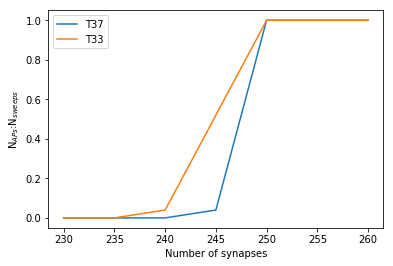

In [71]:
plot(b37[0],b37[1], label='T37')
plot(acc_l33[0][0],acc_l33[0][1], label='T33')
xlabel('Number of synapses')
ylabel('N$_{APs}$:N$_{sweeps}$')
legend()

-----

In [16]:
N_trials = 32
%time acc_r1 = [count_synapses(range(240,321,10),tonotopy='random') for i in range(N_trials)]
nsynsr,countsr = mean(acc_r1,axis=0).T
acc_r1 = [array(acc_r1[i]).T for i in range(N_trials - 1)]

300 synapses, spike ratio: 1.00

CPU times: user 5h 46min 56s, sys: 19.2 s, total: 5h 47min 15s
Wall time: 11h 9min 36s


320 synapses, spike ratio: 1.00

In [43]:
nsynsr=acc_r1[0][0]
countsr_std=std(acc_r1,axis=0)[1]

In [337]:
nsynsl3,countsl3 = array(acc_l3)[0].T

In [43]:
# svdat('Count_syn_random_37.txt', acc_r1) # T=37
for fn, dat in zip(['Count_syn_ordered.txt','Count_syn_random.txt'],[acc_l33,acc_r1]):
    svdat(fn,dat)

In [45]:
a=loadtxt('Count_syn_random.txt') 
a37=loadtxt('Count_syn_random_37.txt')

b=loadtxt('Count_syn_ordered.txt')
b37 = loadtxt('Count_syn_ordered_37.txt')

In [50]:
# random synapses T=33
nsynsr = a[0]
countsr = mean(a[1:],axis=0)
countsr_std =std(a[1:],axis=0)

# T=37
countsr37 = mean(a37[1:],axis=0)
countsr37_std =std(a37[1:],axis=0)

# ordered synapses, T=33
nsynsl = b[0]
countsl = mean(b[1:],axis=0)

In [79]:
path = '/Users/lampochka/Desktop/NerSci/Articles_my/1-Octopus_cells-Energy/Trials/2 - JTheoBiol'

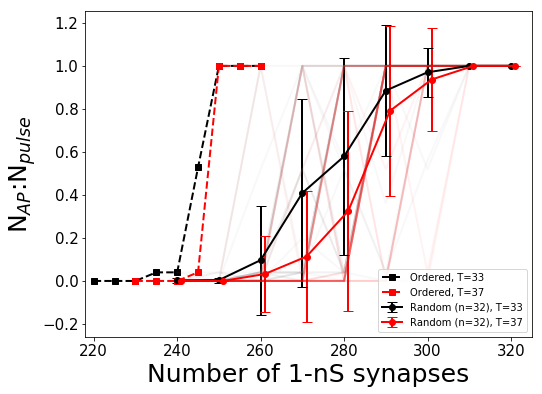

In [81]:
f,ax = subplots(figsize=(8,6))
# Temperature 33 degC
ax.plot(nsynsl,countsl, 'ks--',markersize=6, linewidth=2, label='Ordered, T=33',alpha=1.0)
for i in range(31):
    ax.plot(a[0], a[i+1], 'k-',markersize=6,linewidth=2, color='gray', alpha=0.05)
ax.errorbar(nsynsr,countsr,yerr=countsr_std,fmt='ok-', alpha=1.,lw=2, capsize=5, label='Random (n=32), T=33')

# Temperature 37 degC
ax.plot(b37[0],b37[1], 'rs--',markersize=6, linewidth=2, label='Ordered, T=37',alpha=1.0)
for i in range(31):
    ax.plot(a37[0], a37[i+1], 'r-',markersize=6,linewidth=2, alpha=0.05)
ax.errorbar(nsynsr+1,countsr37,yerr=countsr37_std,fmt='or-', alpha=1.,lw=2, capsize=5, label='Random (n=32), T=37')    

ax.set_xlim(218,325)
ax.legend(loc='lower right', fontsize=10)
ax.set_xlabel('Number of 1-nS synapses', fontsize=25)
ax.set_ylabel('N$_{AP}$:N$_{pulse}$',fontsize=25)
# ax.set_ylim(-0.05,1.05)
ax.tick_params(labelsize=15)
# savefig(path+'/Random-Ordered-Temperature.svg') 

# Record energy use in compartments

In [13]:
h.celsius = 33 # 37

In [14]:
%%time

Ntrials = 5
data_r = []
rate = 256.
for i in range(Ntrials):
    oc = OctopusCell()
    oc.add_synapses(tonotopy='random',gsyn=1.0, Nsyn=300, aud_rate=rate,)
    data_r.append(go([oc], mode='hkl',tstop=240,atwla=True)[0])
    oc.delete()
    del oc

                                         
                                         
                                         
                                         
 model time: 240.00000 ms 

CPU times: user 2h 6min 50s, sys: 17min 41s, total: 2h 24min 32s
Wall time: 2h 12min 8s


In [15]:
with open('Ordered_vs_random/Traces_randomsyn_AL_37_1.pkl','wb') as f:
    pickle.dump(data_r,f,2)

In [166]:
%%time
# Ordered
rate = 256.
oc1 = OctopusCell()
oc1.add_synapses(tonotopy='ordered',gsyn=1.0, Nsyn=250, aud_rate=rate)
data_o_al33 = go([oc1],mode='hkl',tstop=230, atwla=True)
oc1.delete()
del oc1

 model time: 229.98500 ms 

CPU times: user 24min 48s, sys: 3min 43s, total: 28min 32s
Wall time: 25min 42s


In [176]:
with open('Ordered_vs_random/Traces_orderedsyn_AL.pkl','wb') as f:
    pickle.dump(data_o_al33,f,2)

In [ ]:
# Save data
# # !mkdir Ordered_vs_random
# with open('Ordered_vs_random/Traces_orderedsyn.pkl','wb') as f:
#     pickle.dump(data_o,f,2)

# with open('Ordered_vs_random/Traces_randomsyn.pkl','wb') as f:
#     pickle.dump(data_r,f,2)

In [3]:
# Loading data obtained with Biophysical method
with open('Ordered_vs_random/Traces_orderedsyn.pkl','rb') as f:
    data_o = pickle.load(f)
with open('Ordered_vs_random/Traces_orderedsyn_37.pkl','rb') as f:
    data_o37 = pickle.load(f)
    
with open('Ordered_vs_random/Traces_randomsyn.pkl','rb') as f:
    data_r = pickle.load(f)
with open('Ordered_vs_random/Traces_randomsyn_37.pkl','rb') as f:
    data_r37 = pickle.load(f)

In [19]:
# Loading data obtained with Ion-counting method
with open('Ordered_vs_random/Traces_orderedsyn_AL.pkl', 'rb') as f:
    dataAL_o = pickle.load(f)
with open('Ordered_vs_random/Traces_randomsyn_AL_33_0.pkl', 'rb') as f:
    dataAL_r = pickle.load(f)

with open('Ordered_vs_random/Traces_orderedsyn_AL_37.pkl', 'rb') as f:
    dataAL_o37 = pickle.load(f)
with open('Ordered_vs_random/Traces_randomsyn_AL_37.pkl', 'rb') as f:
    dataAL_r37 = pickle.load(f)

------
------
AL-direct energy use before spikes initiated

In [20]:
def get_totale(vec):
    totale = array([v['axon.erate'] + v['soma.erate']+ v['dend.erate']+ v['syn.erate'] for v in vec])
    return mean(totale, axis=0)

In [21]:
def get_restinge(vec, tvec, tcut):
    cut = find_nearest(tvec, 90.)
    return vec[cut]

In [22]:
print('Total resting energy. AL-direct before spikes (ATPs/s)\n')
for v, k in zip([dataAL_o, dataAL_r, dataAL_o37, dataAL_r37],['ordered', 'random', 'ord 37', 'rand 37']):
    val = get_restinge(vec=get_totale(v),
                tvec=dataAL_o[0]['t'],
                tcut=90.)
    print('%s:  \t %.2e'%(k, val))

Total resting energy. AL-direct before spikes (ATPs/s)

ordered:  	 3.72e+09
random:  	 3.72e+09
ord 37:  	 3.67e+09
rand 37:  	 3.67e+09


In [29]:
print('AL-direct:Mouj ratio for a spike: %.1f'%(3.7/1.5))

AL-direct:Mouj ratio for a spike: 2.5


-------
Distribution between compartments

In [61]:
for k in ['axon.erate', 'soma.erate', 'dend.erate', 'syn.erate']:
    val = get_restinge(dataAL_o[0][k], tvec=dataAL_o[0]['t'], tcut=90)
    print('%s: \t %.2e'%(k, val))


axon.erate: 	 3.89e+05
soma.erate: 	 2.66e+09
dend.erate: 	 1.06e+09
syn.erate: 	 0.00e+00


-------
Single Spike energy and distribution

1) Total spike energy

(100, 106)

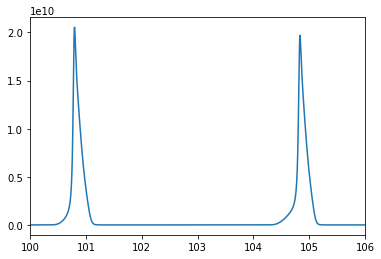

In [141]:
plot(dataAL_o[0]['t'], dataAL_o[0]['axon.erate'])
xlim(100,106)

Extract resting energy for 4 ms

In [158]:
t0, t1 = find_nearest(dataAL_o[0]['t'], 100), find_nearest(dataAL_o[0]['t'], 150)
Nspikes = 13

print('Average AP energy (ATPs/AP)\n')
for v, k in zip([dataAL_o, dataAL_r, dataAL_o37, dataAL_r37],['ordered', 'random', 'ord 37', 'rand 37']):
    vec = get_totale(v)[t0:t1]
    tvec = dataAL_o[0]['t'][t0:t1]
    Espike = trapz(vec, tvec)/1e3/Nspikes - 3.72e9*0.004 # rough spike energy estimate + correction for interspike 'resting' energy
    print('%s: \t %.2e'%(k, Espike))

Average AP energy (ATPs/AP)

ordered: 	 1.69e+07
random: 	 1.96e+07
ord 37: 	 1.55e+07
rand 37: 	 1.81e+07


In [159]:
mean([1.69, 1.96, 1.55, 1.81])

1.7525

2) Distribution between compartments

In [102]:
t0, t1 = find_nearest(dataAL_o[0]['t'], 100), find_nearest(dataAL_o[0]['t'], 150)
Nspikes = 13

acc = {}

print('Average AP energy (ATPs/AP)\n')
for v, k in zip([dataAL_o, dataAL_r, dataAL_o37, dataAL_r37],['ordered', 'random', 'ord 37', 'rand 37']):
    acc[k] = {}
#     print(k + '\n--------')
    for comp in ['axon.erate', 'soma.erate', 'dend.erate', 'syn.erate']:
        vec = mean(array([v[i][comp][t0:t1] for i in range(len(v))]), 
                   axis=0) # averaging over trials in random recs
        
        tvec = dataAL_o[0]['t'][t0:t1]
        Espike = trapz(vec, tvec)/1e3/Nspikes # rough spike energy estimate
        acc[k][comp] = Espike
#         print('%s: \t %.2e'%(comp, Espike))

Average AP energy (ATPs/AP)



Text(0.5,1,'Temperature: 33 degC')

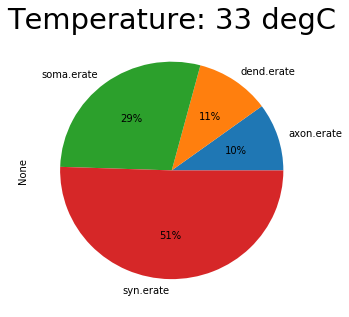

In [129]:
pandas.DataFrame(acc)[['ordered', 'random']].mean(axis=1).plot.pie(autopct='%1.0f%%', subplots=0, figsize=(5,5), legend=0)
# pandas.DataFrame(acc).plot.pie(autopct='%1.0f%%', subplots=True, figsize=(15,3.5), legend=0)
title('Temperature: 33 degC', fontsize=29)

Text(0.5,1,'Temperature: 37 degC')

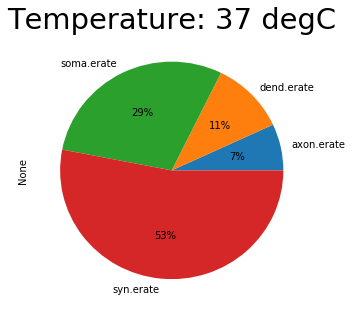

In [130]:
pandas.DataFrame(acc)[['ord 37', 'rand 37']].mean(axis=1).plot.pie(autopct='%1.0f%%', subplots=0, figsize=(5,5), legend=0)
title('Temperature: 37 degC', fontsize=29)

-------------
--------

(150, 153)

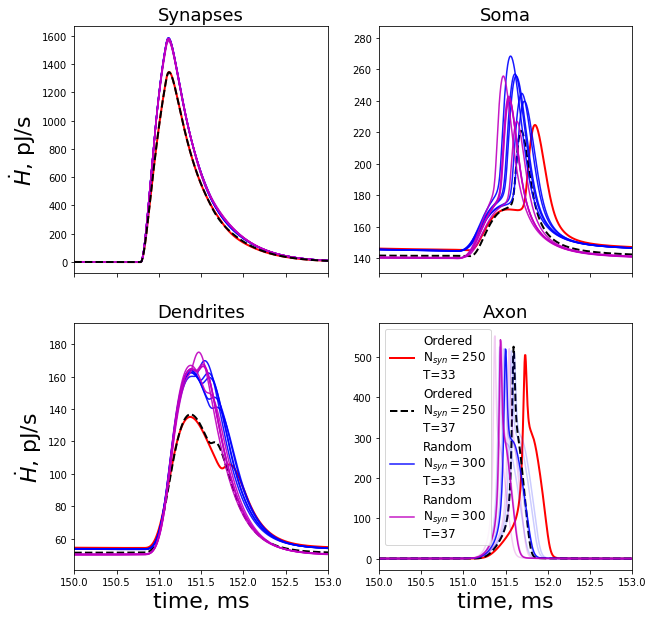

In [5]:
d_o = data_o
d_o37 = data_o37
d_r = data_r
d_r37 = data_r37

x_0,x_1 = 150,153
N_trials = 5 # number of random-syn records

f,ax=subplots(2,2,figsize=(10,10), sharex=True)

# subplot(2,2,3)
ax[1][0].plot(d_o[0]['t'], d_o[0]['dend.erate'], label='ordered',lw=2, color='r')
ax[1][0].plot(d_o37[0]['t'], d_o37[0]['dend.erate'], label='ordered',lw=2, color='k', linestyle='--')

for i in range(N_trials):
    ax[1][0].plot(d_r[i]['t'], d_r[i]['dend.erate'], label='random', color='b', alpha=0.9)
for i in range(5):
    ax[1][0].plot(d_r37[i]['t'], d_r37[i]['dend.erate'], label='random', color='m', alpha=0.9)
    
# plot(oc3_traj['t'], oc3_traj['dend.erate'], label='func-ordered')
ax[1][0].set_title('Dendrites',fontsize=18)
ax[1][0].set_xlabel('time, ms', fontsize=22)
ax[1][0].set_ylabel('$\dot{H}$, pJ/s', fontsize=22)
ax[1][0].set_xlim(x_0,x_1)
# ax[1][0].yaxis.set_ticks(np.arange(60,181,40))

# subplot(2,2,2)
ax[0][1].plot(d_o[0]['t'], d_o[0]['soma.erate'], label='ordered',lw=2, color='r')
ax[0][1].plot(d_o37[0]['t'], d_o37[0]['soma.erate'], label='ordered',lw=2, color='k', linestyle='--')

for i in range(N_trials):
    ax[0][1].plot(d_r[i]['t'], d_r[i]['soma.erate'], label='random', color='b', alpha=0.9)
for i in range(5):
    ax[0][1].plot(d_r37[i]['t'], d_r37[i]['soma.erate'], label='random', color='m', alpha=0.9)
    
# plot(oc3_traj['t'], oc3_traj['soma.erate'], label='func-ordered')
ax[0][1].set_title('Soma',fontsize=18)
# xlabel('time, ms')
#ylabel('E rate, pJ/s')
#legend()
ax[0][1].set_xlim(x_0,x_1)
# ax[0][1].yaxis.set_ticks(np.arange(140,301,40))

# subplot(2,2,1)
ax[0][0].plot(d_o[0]['t'], d_o[0]['syn.erate'], label='ordered',lw=2, color='r')


for i in range(N_trials):
    ax[0][0].plot(d_r[i]['t'], d_r[i]['syn.erate'], label='random', color='b', alpha=0.9)
for i in range(5):
    ax[0][0].plot(d_r37[i]['t'], d_r37[i]['syn.erate'], label='random', color='m', alpha=0.9)
ax[0][0].plot(d_o37[0]['t'], d_o37[0]['syn.erate'], label='ordered',lw=2, color='k', linestyle='--')

# plot(oc3_traj['t'], oc3_traj['syn.erate'], label='func-ordered')
ax[0][0].set_title('Synapses',fontsize=18)
# xlabel('time, ms')
ax[0][0].set_ylabel('$\dot{H}$, pJ/s', fontsize=22)
#legend()
ax[0][0].set_xlim(x_0,x_1)
# ax[0][0].yaxis.set_ticks(np.arange(0,1801,400))

# subplot(2,2,4)
ax[1][1].axes.locator_params(axis='y', nticks=4)
ax[1][1].plot(d_o[0]['t'], d_o[0]['axon.erate'], label='Ordered\nN$_{syn}=250$\nT=33',lw=2, color='r')
ax[1][1].plot(d_o37[0]['t'], d_o37[0]['axon.erate'], label='Ordered\nN$_{syn}=250$\nT=37',lw=2, color='k', linestyle='--')

for i in range(N_trials):
    if i == 0:
        ax[1][1].plot(d_r[i]['t'], d_r[i]['axon.erate'], label='Random\nN$_{syn}=300$\nT=33', color='b', alpha=0.9)
    else:
        ax[1][1].plot(d_r[i]['t'], d_r[i]['axon.erate'], color='b', alpha=0.2)

for i in range(5):
    if i == 0:
        ax[1][1].plot(d_r37[i]['t'], d_r37[i]['axon.erate'], label='Random\nN$_{syn}=300$\nT=37', color='m', alpha=0.9)
    else:
        ax[1][1].plot(d_r37[i]['t'], d_r37[i]['axon.erate'], color='m', alpha=0.2)
        
        
# plot(oc3_traj['t'], oc3_traj['axon.erate'], label='func-ordered')
ax[1][1].set_title('Axon',fontsize=18)
ax[1][1].set_xlabel('time, ms', fontsize=22)
# ylabel('E rate, pJ/s', fontsize=22)
ax[1][1].legend(loc='best',fontsize=12)
ax[1][1].set_xlim(x_0,x_1)
# ax[1][1].yaxis.set_ticks(np.arange(0,501,150))

# savefig('Ordered-random-Erate-curves_temperatures.jpg') # OK!

In [6]:
# Params for spikes integration. Manually determined by looking at the 'plotThreshWdthIntgl' func output: 
# points go in relatively smooth manner over spikes

SpikeSearchParams={'dend':  {'efelTh':115, 'Shifts':[-1.6,+1.6], 'scale':0.1, 'fixedthresh':None},
                   'soma':  {'efelTh':180, 'Shifts':[-1.6,+1.6], 'scale':0.05, 'fixedthresh':None},
                   'axon':  {'efelTh':100, 'Shifts':[-1.6,+1.6], 'scale':0.1, 'fixedthresh':25},
                   'syn':   {'efelTh':100, 'Shifts':[-1.6,+2], 'scale':0.1, 'fixedthresh':100}}

### Calculate energy usage per spike in compartments and synaptic currents

In [15]:
# Does not work with recs obtained wiht Ion-counting.

d_o = data_o
d_o37 = data_o37
d_r = data_r
d_r37 = data_r37

accr = IntegrateSpikesFinal(data_r,SSP=SpikeSearchParams,plott=0)
accr37 = IntegrateSpikesFinal(d_r37,SSP=SpikeSearchParams,plott=0)

acco = IntegrateSpikesFinal(d_o,SSP=SpikeSearchParams,plott=0)
acco37 = IntegrateSpikesFinal(d_o37,SSP=SpikeSearchParams,plott=0)

### Integration windows calculated for AP energy use

In [22]:
print 'Integration windows calculated for AP energy use\n================================================'
for vec,cond in zip([accr37, accr, acco37, acco],['random37', 'random', 'ordered37', 'ordered']):
    print '\n '+cond + '\n>------------'
    widths = {}
    for cell in ['axon', 'soma', 'dend','syn']:
        widths[cell] = vec[0][cell]['Spike_width'].mean()
        print '%s \t %.2f'%(cell,widths[cell])

    print 'Averaged over dend and soma: %.2f'%(mean([widths['dend'],widths['soma']])) # averaging over dend and soma because syn and axon have zero resting energy

Integration windows calculated for AP energy use

 random37
>------------
axon 	 0.37
soma 	 1.11
dend 	 1.18
syn 	 1.38
Averaged over dend and soma: 1.15

 random
>------------
axon 	 0.50
soma 	 1.13
dend 	 1.24
syn 	 1.38
Averaged over dend and soma: 1.19

 ordered37
>------------
axon 	 0.43
soma 	 1.15
dend 	 1.25
syn 	 1.31
Averaged over dend and soma: 1.20

 ordered
>------------
axon 	 0.62
soma 	 1.24
dend 	 1.35
syn 	 1.30
Averaged over dend and soma: 1.30


In [44]:
1e3/1.13

884.9557522123895

### Thus, at 33 degC use resting energy for 1.25 ms time interval => Use $\text{division_factor}$ for resting energy $=800$
### At 37 degC use resting energy for 1.13 ms => $\text{division_factor}$ for resting energy $=885$

(0, 0.1)

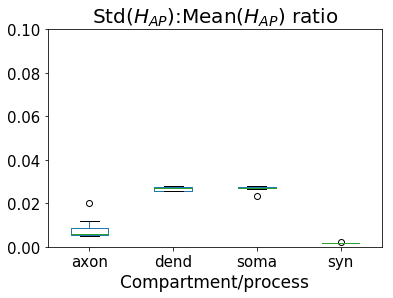

In [28]:
acl = {cpt:[accr[i][cpt]['Spike_integral'].std()/accr[i][cpt]['Spike_integral'].mean() for i in range(10)] for cpt in accr[0].keys()}

f,ax = subplots()
ax.set_title('Std($H_{AP}$):Mean($H_{AP}$) ratio', fontsize=20)
pandas.DataFrame(acl).plot.box(ax=ax)
# ax.set_ylabel('Std($H_{AP}$):Mean($H_{AP}$) ratio',fontsize=17)
ax.tick_params(labelsize=15)
ax.set_xlabel('Compartment/process',fontsize=17)
ax.set_ylim(0,.1)

In [49]:
IntegralsToPlot = {'ordered':{},'ordered37':{},'random':{}, 'random37':{}}
for k,v in acco[0].items():
    IntegralsToPlot['ordered'][k] = (v['Spike_integral']).mean()
    IntegralsToPlot['ordered37'][k] = (acco37[0][k]['Spike_integral']).mean()
    IntegralsToPlot['random'][k] = array([(vec[k]['Spike_integral']).mean() for vec in accr]) # over trials with random synapses
    IntegralsToPlot['random37'][k] = array([(vec[k]['Spike_integral']).mean() for vec in accr37]) # over trials with random synapses

In [51]:
# AP-related energy use in the model. Summ over dend, axon, and soma. No Synapses included
# NOTE. Check if the Baseline is subtractedb (ctrl+f ->'bsl')
print 'Total energy usage (ATPs/AP) in case of ordered and random synapses:\n------------'
print 'Ordered \t%.2e'%(float(pandas.DataFrame(IntegralsToPlot['ordered'],index=[0])[['axon','soma','dend','syn']].sum(axis=1)))
print 'Ordered37 \t%.2e'%(float(pandas.DataFrame(IntegralsToPlot['ordered37'],index=[0])[['axon','soma','dend','syn']].sum(axis=1)))
print 'Random  \t%.2e'%(pandas.DataFrame(IntegralsToPlot['random']).mean()[['axon','soma','dend','syn']].sum())
print 'Random37  \t%.2e'%(pandas.DataFrame(IntegralsToPlot['random37']).mean()[['axon','soma','dend','syn']].sum())

Total energy usage (ATPs/AP) in case of ordered and random synapses:
------------
Ordered 	1.46e+07
Ordered37 	1.38e+07
Random  	1.63e+07
Random37  	1.57e+07


In [24]:
mean([1.46e+07,1.38e+07,1.63e+07,1.57e+07])/1e7

1.51

In [78]:
print 1.46e+07/1.63e+07, 1.38e+07/1.57e+07

0.895705521472 0.87898089172


In [54]:
# Units: 1e7 ATPs/AP (!)
data_tp = pandas.DataFrame([IntegralsToPlot['ordered'],IntegralsToPlot['ordered37'],
                            pandas.DataFrame(IntegralsToPlot['random']).mean(),
                           pandas.DataFrame(IntegralsToPlot['random37']).mean()],index=['Ordered', 'Ordered37','Random', 'Random37']).T/1e7

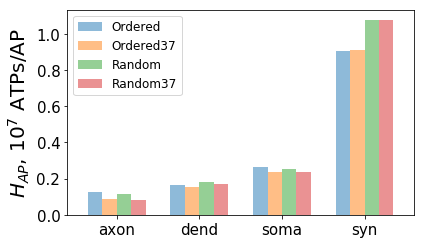

In [55]:
f,ax = subplots(figsize=(6,3.5))
data_tp.plot.bar(ax=ax,rot=0,alpha=0.5,width=0.7)
ax.tick_params(labelsize=15)
ax.legend(fontsize=12)
ax.set_ylabel('$H_{AP}$, 10$^7$ ATPs/AP',fontsize=20)
tight_layout()
# savefig('Compartments_Erates_noPropagation.pdf')

In [60]:
data_tp37 = data_tp[['Ordered37', 'Random37']]

In [62]:
data_tp33 = data_tp[['Ordered', 'Random']]

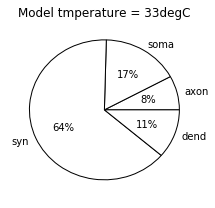

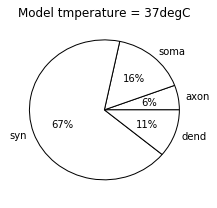

In [64]:
for temper, data in zip(['33','37'],[data_tp33,data_tp37]):

    f,ax = subplots(figsize=(3,3))
    wedges = ax.pie(dict(data.mean(axis=1)).values(),labels=dict(data_tp.mean(axis=1)).keys(),
                           colors=['w'],autopct='%1.0f%%')
    ax.set_title('Model tmperature = %sdegC'%temper)

    for w in wedges[0]:
        w.set_linewidth(1)
        w.set_edgecolor('k')
    tight_layout()
    # savefig('Pie_Chart_Compartments-Mean_over_rand_ordered_noPropagation.pdf')

# Recalculate the energy distribution between compartments to  distribution between processes

In [75]:
# for calculation of resting energy. Run up to first syn activation and take the last values over time to calculate 
# resting energy
h.celsius = 37
h.tstop = 90
h.run()

0.0

In [76]:
# After stimulation the cell is in the rest. Calculate instant restin energy 
division_factor = 885. # 885 for 37degC and 800 for 33degC
ocErst37 = list(pmol2molecules(J2atp(array(instant_erates(oc1,mode='hkl')), F_ATP=50))/division_factor) # axon, soma, dend, syn, ih, ikl
ocErst37.append(sum(ocErst37) - sum(ocErst37[-2:])) # axon, soma, dend, syn,ih, ikl, total
ocErst37 = {k:v for k,v in zip(['axon.erate','soma.erate','dend.erate','syn.erate','ih.erate','ikl.erate','total.erate'], ocErst37)}

In [71]:
# ---- Distribution of energy use between processes --- ('energy budget', Attwell & laughlin, 2001)
def calc_budget(E_active, Erest):
    E_rest = ocErst['total.erate']
    E_active = data.sum().mean()*1e7
    E_syn = data.mean(axis=1)['syn']*1e7
    E_AP = E_active - E_rest - E_syn

    E_processes = {'AP':E_AP,'RP':E_rest,'Presyn':E_syn}
    # E_processes = pandas.DataFrame(E_processes, ['0'])
    return E_processes

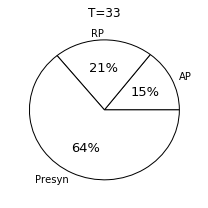

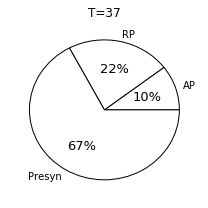

In [77]:
for temper, data, erest in zip(['33', '37'],[data_tp33,data_tp37], [ocErst, ocErst37]):
    E_processes = calc_budget(data, Erest=erest)
    
    f,ax = subplots(figsize=(3,3))
    ax.set_title('T=%s'%temper)
    wedges = ax.pie(E_processes.values(),labels=E_processes.keys(),colors=['w'],autopct='%1.0f%%',textprops={'fontsize': 13})
    for w in wedges[0]:
        w.set_linewidth(1)
        w.set_edgecolor('k')
    tight_layout()
    # savefig('Pie_Chart-Processes-Mean_over_rand_ordered_noPropagation.pdf')

## Plot AP-related energy figure: compare OCs to other CNS cells
Use the supplementary for Howarth et al., 2012 paper to calculate AP-related energy of 'other CNS cells'

In [51]:
OC_AP_related = data_tp.sum().mean()*1e7 # multiply by 1e7 cause 'data_tp' is in units of 1e7 ATPs/AP 

Pyr_AP = 5.1e5 + 2.14e7  # Resting energy rescaled to AP duration (1.5 ms) + AP-related with Axon energy rescaled to Axon length = 35 um (OC initial axonsegment)
Pur_AP = 7.2e5  + 9e7    # RP + Single Simple spike (Axon length doesn't matter cause Axon energy ~ 1e5, but dendritic ~ 1e7)
Grn_AP = 1.89e5 + 5.04e5 # Axon energy rescaled to ax length = 35um

In [52]:
AP_related = {'OC':OC_AP_related, 'Pur':Pur_AP, 'Pyr':Pyr_AP, 'Grn':Grn_AP} # from *.xlsx table supplement to the Howarth et al 2012 paper
D = {'OC':1e-3, 'Pur':1e-3, 'Pyr':1e-3, 'Grn':1e-3}
AP_related = pandas.DataFrame([D,AP_related],['O','D'])

In [ ]:
# font = {'family' : 'times',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

fig,ax = subplots(figsize=(5,3), sharex=True)
AP_related.T.plot.bar(ax=ax,stacked=True,
              color=['grey','grey','#b0c4de'],rot=0,
              width=.85, legend=0)
ax.set_ylabel('$H_{AP}$, ATPs/AP',fontsize=15)
yscale('log')
ax.set_ylim(0.7e5,1.3e8)
# from matplotlib.ticker import ScalarFormatter
# ax.yaxis.set_major_formatter(ScalarFormatter())
tight_layout()
# savefig('Corrected_AP_energy.pdf')

-------

In [91]:
# ap_related_energY_
ocElin = integrate_all(data=data_o[0], x_boarders=[150,152],mode=1)
ocElin37 = integrate_all(data=data_o37[0], x_boarders=[150,152],mode=1)

In [93]:
# for bar plot

def Erandom(data):
    ocEran_ = []
    for i in range(len(data)):
        ocEran_.append(integrate_all(data[i], x_boarders=[100,102], mode=1))

    vv = []
    for i in range(len(ocEran_)):
        vv.append([v for k,v in ocEran_[i].items()])

    ocEran_mean = {k:v for k,v in zip(ocElin.keys(), mean(vv, axis=0))}
    ocEran_std = {k:v for k,v in zip(ocElin.keys(), std(vv, axis=0))}
    
    return ocEran_mean, ocEran_std

In [94]:
ocEran_mean, ocEran_std = Erandom(data=data_r)
ocEran_mean37, ocEran_std37 = Erandom(data=data_r37)

In [95]:
# for article
P = pandas.DataFrame(data=[ocErst,ocElin,ocEran_mean],
                     index=['Rest','Ordered','Random'])
print P
print '\nATPs consumed during 2 ms! T=33'

           axon.erate    dend.erate      ih.erate     ikl.erate    soma.erate  \
Rest     1.562611e+03  9.362641e+05  3.151484e+06  1.321022e+05  2.360562e+06   
Ordered  1.292771e+06  6.923095e+05 -2.605927e+05  6.971814e+05  3.560940e+05   
Random   1.143684e+06  1.042135e+06 -3.355835e+05  1.093579e+06  5.759731e+05   

            syn.erate   total.erate  
Rest     0.000000e+00  3.298389e+06  
Ordered  8.897828e+06  1.123900e+07  
Random   1.102336e+07  1.378515e+07  

ATPs consumed during 2 ms! T=33


In [96]:
# for article
P = pandas.DataFrame(data=[ocErst37,ocElin37,ocEran_mean37],
                     index=['Rest','Ordered','Random'])
print P
print '\nATPs consumed during 2 ms! T=37'

            axon.erate     dend.erate      ih.erate     ikl.erate  \
Rest       1389.447660  841732.692112  2.816769e+06  1.180086e+05   
Ordered  895923.989633  714204.157763  3.956555e+05  7.108263e+05   
Random   832752.812162  988293.313647 -3.344704e+05  1.028286e+06   

           soma.erate     syn.erate   total.erate  
Rest     2.104683e+06  0.000000e+00  2.947805e+06  
Ordered  3.446754e+05  8.900239e+06  1.085504e+07  
Random   4.649129e+05  1.109746e+07  1.338342e+07  

ATPs consumed during 2 ms! T=37


In [97]:
ocErst_std = {k:None for k in ocErst.keys()}
ocErst_std37 = {k:None for k in ocErst37.keys()}

In [678]:
# Restin = {'Axon':    2.417893e+03,
# 'Dend' :   1.480578e+06,
# 'Soma':    3.703902e+06,
# 'Syn':    -1.561064e-66}

In [203]:
Ordered = {'axon':1.147325e+06,'dend':2.250578e+06,'soma':4.092950e+06,'syn':9.335638e+06}
Random = {'axon':1.115740e+06,'dend':2.479649e+06,'soma':4.188929e+06,'syn':1.099649e+07}

In [102]:
# Impacts of Ih and Ikl for 2 ms, REST
def print_hkl_impacts(ocE, state, temper='33'):
#     a = find_nearest(data_o['t'],250)
    print 'Energy in %s OC for 2 ms T=%s\n------------'%(state, temper)
    print 'Ih   : %.2e'%(ocE['ih.erate'])
    print 'Ikl  : %.2e'%(ocE['ikl.erate'])
    print 'Total: %.2e'%(ocE['total.erate'])
    print '--\nIh and Ikl impacts to %s Erate (fractions):\n %.3f, %.3f\n\n'%(state,
                                                                              ocE['ih.erate']/ocE['total.erate'],
                                                                              ocE['ikl.erate']/ocE['total.erate'])
    return

In [103]:
for d,s in zip([ocElin,ocErst],['AP','resting']):
    print_hkl_impacts(d,s)

Energy in AP OC for 2 ms T=33
------------
Ih   : -2.61e+05
Ikl  : 6.97e+05
Total: 1.12e+07
--
Ih and Ikl impacts to AP Erate (fractions):
 -0.023, 0.062


Energy in resting OC for 2 ms T=33
------------
Ih   : 3.15e+06
Ikl  : 1.32e+05
Total: 3.30e+06
--
Ih and Ikl impacts to resting Erate (fractions):
 0.955, 0.040




In [105]:
for d,s in zip([ocElin37,ocErst37],['AP','resting']):
    print_hkl_impacts(d,s,temper='37')

Energy in AP OC for 2 ms T=37
------------
Ih   : 3.96e+05
Ikl  : 7.11e+05
Total: 1.09e+07
--
Ih and Ikl impacts to AP Erate (fractions):
 0.036, 0.065


Energy in resting OC for 2 ms T=37
------------
Ih   : 2.82e+06
Ikl  : 1.18e+05
Total: 2.95e+06
--
Ih and Ikl impacts to resting Erate (fractions):
 0.956, 0.040




#### Thus, impact of Ih and Ikl to the overall resting energy usage by OC is the same for 33 and 37degC

## Comparing OC vs other neurons energy 

In [106]:
# resting values from jcbfm table, supplementary to Howarth et al 2012:
Grn = 9.45e7
Pur = 7.18e8 
Pyr = 3.4e8 

In [107]:
Mesr ={'OC':[ocErst['total.erate']*800, ocErst['ih.erate']*800,ocErst['ikl.erate']*800], # [Total, Ih, Ikl] 
      'Pur':[Pur], 'Grn':[Grn], 'Pyr':[Pyr]}

Mesr37 ={'OC':[ocErst37['total.erate']*885, ocErst37['ih.erate']*885,ocErst37['ikl.erate']*885], # [Total, Ih, Ikl] 
      'Pur':[Pur], 'Grn':[Grn], 'Pyr':[Pyr]}

In [108]:
# fill 'ih' and 'ikl' fields of 'other cns cells' with zeros
def fill_mesr(mesr):
    for k,v in mesr.items():
        if k != 'OC':
            mesr[k] = concatenate((v,[0.,0.]))
        else:
            mesr['OC'] = array(mesr['OC'])
    return mesr

In [109]:
Mesr = fill_mesr(Mesr)
Mesr37 = fill_mesr(Mesr37)

In [110]:
Mesr['OC'][0] = Mesr['OC'][0] - Mesr['OC'][1] - Mesr['OC'][2]
Mesr = pandas.DataFrame(Mesr,index=['Other','$g_h$','$g_{kl}$']).T

In [111]:
Mesr37['OC'][0] = Mesr37['OC'][0] - Mesr37['OC'][1] - Mesr37['OC'][2]
Mesr37 = pandas.DataFrame(Mesr37,index=['Other','$g_h$','$g_{kl}$']).T

In [117]:
Mesr.sum(axis=1)

Grn    9.450000e+07
OC     2.638711e+09
Pur    7.180000e+08
Pyr    3.400000e+08
dtype: float64

In [118]:
Mesr37.sum(axis=1)

Grn    9.450000e+07
OC     2.608808e+09
Pur    7.180000e+08
Pyr    3.400000e+08
dtype: float64

In [114]:
font = {'family' : 'times',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

In [ ]:
OC_total_rest = Mesr.loc['OC'].sum()
print 'Ratio OC resting energy to Other neuron energy\n'

print '{} \t {}'.format('neuron', 'ratio')
for cl in Mesr.iterrows():
    if cl[0] != 'OC':
        print '%s : \t %.1f'%(cl[0], OC_total_rest/cl[1]['Other'])

Text(0.5,1,'T=33degC')

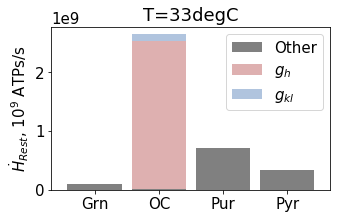

In [115]:
fig,ax = subplots( figsize=(5,3), sharex=True)
# ax[0].set_title('Resting E cost of the neurons.\n Impact of Ih and Ikl into OC Energy',fontsize=15)
Mesr.plot.bar(ax=ax,stacked=True,
              color=['grey','#deb0b0','#b0c4de'],rot=0,
              width=.85)

ax.set_ylabel('$\dot{H}_{Rest}$, $10^9$ ATPs/s')
ax.legend(fontsize=15)
ax.set_title('T=33degC')
# savefig('Distrib-model-energy-bars.pdf')

Text(0.5,1,'T=37degC')

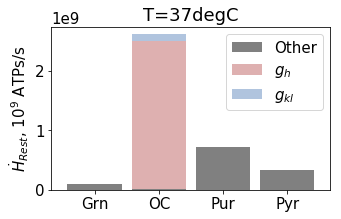

In [116]:
fig,ax = subplots( figsize=(5,3), sharex=True)
# ax[0].set_title('Resting E cost of the neurons.\n Impact of Ih and Ikl into OC Energy',fontsize=15)
Mesr37.plot.bar(ax=ax,stacked=True,
              color=['grey','#deb0b0','#b0c4de'],rot=0,
              width=.85)

ax.set_ylabel('$\dot{H}_{Rest}$, $10^9$ ATPs/s')
ax.legend(fontsize=15)
ax.set_title('T=37degC')
# savefig('Distrib-model-energy-bars.pdf')